In [20]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import optuna
from imblearn.over_sampling import SMOTE
from collections import Counter

In [21]:
epochs = 200
df = pd.read_excel("train_augmented.xlsx", decimal=',')

features = ['V1real', 'V2real']
X = df[features].values.astype(np.float32)
y = df['is_type_2'].values.astype(np.int64)

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [22]:
class SurfaceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [23]:
def get_activation(name):
    if name == 'relu':
        return nn.ReLU()
    elif name == 'tanh':
        return nn.Tanh()
    elif name == 'leaky_relu':
        return nn.LeakyReLU()
    elif name == 'elu':
        return nn.ELU()
    else:
        raise ValueError(f"Unknown activation function: {name}")

In [24]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_rate, activation_name):
        super(Net, self).__init__()
        activation = get_activation(activation_name)
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(activation)
        layers.append(nn.Dropout(dropout_rate))
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(activation)
            layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.Linear(hidden_dim, 2))  # логиты
        self.model = nn.Sequential(*layers)
    def forward(self, x):
        return self.model(x)

In [25]:
def objective(trial):
    hidden_dim = trial.suggest_int('hidden_dim', 2, 256)
    num_layers = trial.suggest_int('num_layers', 2, 10)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.05, 0.5)
    batch_size = trial.suggest_categorical('batch_size', [4, 8, 16, 32, 64])
    activation_name = trial.suggest_categorical('activation', ['relu', 'tanh', 'leaky_relu', 'elu'])
    
    model = Net(
        input_dim=2,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        dropout_rate=dropout_rate,
        activation_name=activation_name
    )
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=train_y)
    weights = torch.tensor(weights, dtype=torch.float32)
    criterion = nn.CrossEntropyLoss(weight=weights)
    train_loader = DataLoader(SurfaceDataset(train_X, train_y), batch_size=batch_size, shuffle=True)
    model.train()
    for epoch in range(epochs):
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(test_X, dtype=torch.float32)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1).numpy()
        f1 = f1_score(test_y, preds)
    return f1

In [26]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=epochs)

print("Best trial:")
print(study.best_trial.params)

[I 2025-05-31 20:25:01,080] A new study created in memory with name: no-name-7be84733-f9de-4275-ae2b-e19dd12d9283
[I 2025-05-31 20:25:13,964] Trial 0 finished with value: 0.7393939393939394 and parameters: {'hidden_dim': 164, 'num_layers': 8, 'lr': 0.0030928913985411016, 'dropout_rate': 0.4076676512119197, 'batch_size': 64, 'activation': 'tanh'}. Best is trial 0 with value: 0.7393939393939394.
[I 2025-05-31 20:27:12,176] Trial 1 finished with value: 0.6766917293233082 and parameters: {'hidden_dim': 70, 'num_layers': 9, 'lr': 0.0007339758266235703, 'dropout_rate': 0.2902727970828239, 'batch_size': 4, 'activation': 'tanh'}. Best is trial 0 with value: 0.7393939393939394.
[I 2025-05-31 20:28:25,557] Trial 2 finished with value: 0.7291666666666666 and parameters: {'hidden_dim': 35, 'num_layers': 5, 'lr': 0.0002049705438858289, 'dropout_rate': 0.32261223833242325, 'batch_size': 4, 'activation': 'elu'}. Best is trial 0 with value: 0.7393939393939394.
[I 2025-05-31 20:30:15,589] Trial 3 finis

Best trial:
{'hidden_dim': 206, 'num_layers': 7, 'lr': 0.00046901273673839467, 'dropout_rate': 0.1744248868035043, 'batch_size': 16, 'activation': 'relu'}


In [27]:
best_params = study.best_trial.params
model = Net(
    input_dim=2,
    hidden_dim=best_params['hidden_dim'],
    num_layers=best_params['num_layers'],
    dropout_rate=best_params['dropout_rate'],
    activation_name=best_params['activation']
)

optimizer = optim.Adam(model.parameters(), lr=best_params['lr'])
weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=train_y)
weights = torch.tensor(weights, dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=weights)

train_loader = DataLoader(SurfaceDataset(train_X, train_y), batch_size=best_params['batch_size'], shuffle=True)


In [28]:
val_f1_history = []
model.train()

for epoch in range(epochs):
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(test_X, dtype=torch.float32)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1).numpy()
        f1 = f1_score(test_y, preds)
        val_f1_history.append(f1)


In [29]:
model.eval()
with torch.no_grad():
    inputs = torch.tensor(test_X, dtype=torch.float32)
    outputs = model(inputs)
    preds = torch.argmax(outputs, dim=1).numpy()

print("Final Accuracy:", accuracy_score(test_y, preds))
print("Final F1 Score:", f1_score(test_y, preds))


Final Accuracy: 0.8095238095238095
Final F1 Score: 0.8


In [30]:
torch.save({
    'model_state_dict': model.state_dict(),
    'params': best_params
}, 'model.pt')
print("Модель сохранена в model.pt")

Модель сохранена в model.pt


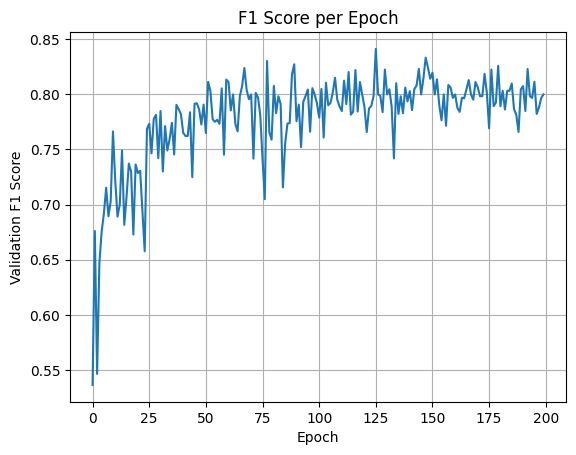

In [31]:
plt.plot(val_f1_history)
plt.xlabel("Epoch")
plt.ylabel("Validation F1 Score")
plt.title("F1 Score per Epoch")
plt.grid(True)
plt.show()
